In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import torchtext
from torchtext.datasets import AG_NEWS
import torchtext.transforms as T
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from tqdm.notebook import trange, tqdm

In [2]:
# Hyperparameters
lr = 1e-4
epochs = 20
batch_size = 32
max_len = 128
root_data_dir = "./data"

In [5]:
classes = ["World","Sports","Business","Science and Technology"]

In [7]:
# dataset and dataloader
train_ds = AG_NEWS(root=root_data_dir,split="train")
test_ds = AG_NEWS(root=root_data_dir,split="test")

In [9]:
# Initialize the tokenizer
tokenizer = get_tokenizer("basic_english")

def yield_token(data_iter):
    for _,text in data_iter:
        yield tokenizer(text)

In [11]:
# build vocabulary
vocab = build_vocab_from_iterator(
    yield_token(train_ds),
    min_freq= 2,
    specials= ["<pad>", "<sos>","<eos>", "<unk>"],
    special_first=True
)
vocab.set_default_index(vocab["<unk>"])

In [12]:
vocab.get_itos()

['<pad>',
 '<sos>',
 '<eos>',
 '<unk>',
 '.',
 'the',
 ',',
 'to',
 'a',
 'of',
 'in',
 'and',
 's',
 'on',
 'for',
 '#39',
 '(',
 ')',
 '-',
 "'",
 'that',
 'with',
 'as',
 'at',
 'is',
 'its',
 'new',
 'by',
 'it',
 'said',
 'reuters',
 'has',
 'from',
 'an',
 'ap',
 'his',
 'will',
 'after',
 'was',
 'us',
 'be',
 'over',
 'have',
 'their',
 '&lt',
 'are',
 'up',
 'quot',
 'but',
 'more',
 'first',
 'two',
 'he',
 'world',
 'u',
 'this',
 '--',
 'company',
 'monday',
 'wednesday',
 'tuesday',
 'oil',
 'out',
 'thursday',
 'one',
 'not',
 'against',
 'inc',
 'friday',
 'into',
 'they',
 'about',
 'last',
 'iraq',
 'year',
 'than',
 'york',
 'yesterday',
 'who',
 'president',
 'microsoft',
 'no',
 'were',
 '?',
 'been',
 'million',
 't',
 'says',
 'week',
 'had',
 'corp',
 'united',
 'game',
 'when',
 'sunday',
 'prices',
 'could',
 'three',
 'would',
 'today',
 'years',
 'group',
 'security',
 'government',
 'time',
 'people',
 'which',
 'may',
 'afp',
 'percent',
 'software',
 '1',


In [13]:
label, text = next(iter(test_ds))
print(text)

Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.


In [14]:
# text trasformation pipeline
text_transform = T.Sequential(
    T.VocabTransform(vocab=vocab),
    T.AddToken(1,begin=True),
    T.Truncate(max_seq_len=max_len),
    T.AddToken(2,begin=False),
    T.ToTensor(padding_value=0)
)

In [19]:
# define tokenizer function
text_tokenizer = lambda batch: [tokenizer(x) for x in batch]

# dataloader
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=4,drop_last=True)
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=False,num_workers=4)

In [21]:
# define model
class LSTM(nn.Module):
    def __init__(self,vocab_size,output_size,num_layers=1,hidden_size=128):
        super(LSTM, self).__init__()
        self.embed = nn.Embedding(vocab_size,hidden_size)
        self.lstm = nn.LSTM(hidden_size,hidden_size,num_layers=num_layers,batch_first= True,dropout=0.5)
        self.fc = nn.Linear(hidden_size,output_size)

    def forward(self,text,hidden_in,mem_in):
        embedding = self.embed(text)
        out,(hidden_out,mem_out) = self.lstm(embedding,(hidden_in,mem_in))
        output = self.fc(out)
        return output, hidden_out, mem_out

In [23]:
vocab_size = len(vocab)
hidden_size = 64
num_layers = 3
output_size = 4

In [25]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [27]:
# Initailize the model, optimizer, loss
model = LSTM(vocab_size,output_size,num_layers,hidden_size).to(device)

In [29]:
model.load_state_dict(torch.load('AGNews.pth'))

<All keys matched successfully>

In [31]:
criterion = F.cross_entropy
optimizer = Adam(model.parameters(),lr=lr)

In [33]:
training_loss_logger = []
test_loss_logger = []
training_acc_logger = []
test_acc_logger = []

In [35]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 3500420 (Approximately 3 Million) Parameters!


In [37]:
len(list(test_dl))

240

In [18]:
def progress_bar(current_batch,total_batches,prefix="",suffix="",decimel=1,length=30,fill="█"):
    """
    Prints a progress bar to the console.
    """
    prefix= f"{current_batch}/{total_batches}"
    percentage = f"{100 * (current_batch/float(total_batches)):{decimel}f}"
    filled_length = int(length * current_batch//total_batches)
    bar = fill * filled_length + "-" * (length - filled_length)
    sys.stdout.write(f"\r{prefix} {percentage}% |{bar}| {suffix}")
    sys.stdout.flush()

In [41]:
%%time
# training loop
for epoch in range(1,epochs+1):
    train_loss = 0
    correct = 0
    model.train()
    step = 0
    for label,text in train_dl:
        bs = label.shape[0]        
        text_tokens = text_transform(text_tokenizer(text)).to(device)
        label = (label - 1).to(device)
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)
        # forward pass
        out, hidden, memory = model(text_tokens,hidden,memory)
        loss = criterion(out[:,-1,:],label)
        train_loss += loss.item()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss_logger.append(loss.item())
        correct += (out[:,-1,:].argmax(1) == label).sum().item()
        step += bs
    train_loss = train_loss/len(list(train_dl))
    train_acc = 100 * correct/step
    training_acc_logger.append(train_acc)

    # evaluation process
    model.eval()
    test_losses = 0
    test_correct = 0
    test_step = 0
    with torch.no_grad():
        for test_label, test_text in test_dl:
            test_text_tokens = text_transform(text_tokenizer(test_text)).to(device)
            test_label = (test_label - 1).to(device)
            test_hidden = torch.zeros(num_layers, test_label.shape[0], hidden_size, device=device)
            test_memory = torch.zeros(num_layers, test_label.shape[0], hidden_size, device=device)
            test_out, test_hidden, test_memory = model(test_text_tokens,test_hidden,test_memory)
            test_loss = criterion(test_out[:,-1,:],test_label)
            test_losses += test_loss.item()
            test_loss_logger.append(test_loss.item())
            test_correct += (test_out[:,-1,:].argmax(1) == test_label).sum().item()
            test_step += test_label.shape[0]
        test_loss = test_losses/len(list(test_dl))
        test_acc = 100 * test_correct/test_step
        test_acc_logger.append(test_acc)
    print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}")

Epoch 1/20, Train Loss: 0.0452, Test Loss: 0.4573, Train Acc: 98.86, Test Acc: 89.78
Epoch 2/20, Train Loss: 0.0443, Test Loss: 0.4743, Train Acc: 98.88, Test Acc: 89.75
Epoch 3/20, Train Loss: 0.0425, Test Loss: 0.4640, Train Acc: 98.91, Test Acc: 89.92
Epoch 4/20, Train Loss: 0.0413, Test Loss: 0.4738, Train Acc: 98.96, Test Acc: 89.61
Epoch 5/20, Train Loss: 0.0401, Test Loss: 0.4993, Train Acc: 98.98, Test Acc: 89.59
Epoch 6/20, Train Loss: 0.0388, Test Loss: 0.4986, Train Acc: 99.04, Test Acc: 89.83
Epoch 7/20, Train Loss: 0.0370, Test Loss: 0.4968, Train Acc: 99.08, Test Acc: 89.30
Epoch 8/20, Train Loss: 0.0359, Test Loss: 0.4994, Train Acc: 99.12, Test Acc: 89.38
Epoch 9/20, Train Loss: 0.0348, Test Loss: 0.5072, Train Acc: 99.15, Test Acc: 89.42
Epoch 10/20, Train Loss: 0.0344, Test Loss: 0.5145, Train Acc: 99.11, Test Acc: 89.34
Epoch 11/20, Train Loss: 0.0328, Test Loss: 0.4991, Train Acc: 99.18, Test Acc: 89.46
Epoch 12/20, Train Loss: 0.0319, Test Loss: 0.5116, Train Acc: 

In [170]:
# evaluation process
model.eval()
test_correct = 0
test_step = 0
with torch.no_grad():
    for test_label, test_text in test_dl:
        test_text_tokens = text_transform(text_tokenizer(test_text)).to(device)
        test_label = (test_label - 1).to(device)
        test_hidden = torch.zeros(num_layers, test_label.shape[0], hidden_size, device=device)
        test_memory = torch.zeros(num_layers, test_label.shape[0], hidden_size, device=device)
        test_out, test_hidden, test_memory = model(test_text_tokens,test_hidden,test_memory)
        test_correct += (test_out[:,-1,:].argmax(1) == test_label).sum().item()
        test_step += test_label.shape[0]
    test_acc = 100 * test_correct/test_step
print(f"{test_correct}/{test_step}, Accuracy: {test_acc:.2f}")

6842/7600, Accuracy: 90.03


In [192]:
torch.save(model.state_dict(),"AGNews.pth")

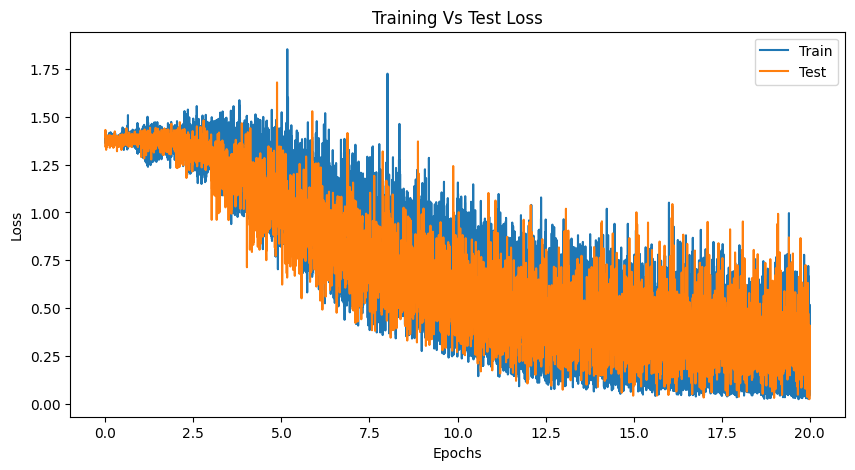

In [41]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, epochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, epochs, len(test_loss_logger)), test_loss_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

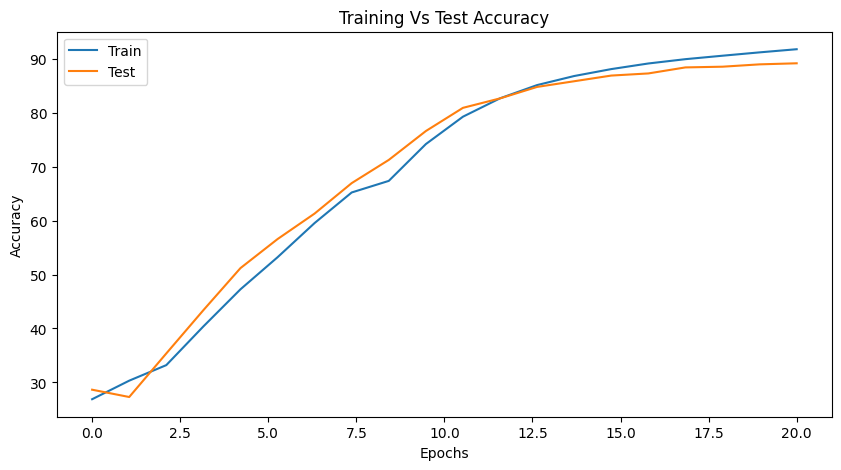

In [45]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, epochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, epochs, len(test_acc_logger)), test_acc_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")

In [49]:
label = []
text = []
for lb,texts in test_dl:
    for l in lb:
        label.append(l)
    for t in texts:
        text.append(t)
test_df = pd.DataFrame({"label":label,"text":text})
test_df.head()

,label,text
0,tensor(3),Fears for T N pension after talks Unions repre...
1,tensor(4),Calif. Aims to Limit Farm-Related Smog (AP) AP...
2,tensor(4),E-mail scam targets police chief Wiltshire Pol...
3,tensor(4),Dutch Retailer Beats Apple to Local Download M...
4,tensor(4),Scientists Discover Ganymede has a Lumpy Inter...


In [166]:
idx = 7596
print(test_df['text'][idx])
token = text_transform(tokenizer(test_df['text'][idx])).to(device)
token.size()
_ = torch.zeros(num_layers,hidden_size,device=device)
__ = torch.zeros(num_layers,hidden_size,device=device)
predict,_,__ = model(token,_,__)
predict = predict[-1,:].argmax(0)
print(f"Original: {classes[(test_df['label'][idx])-1]}, Predicted: {classes[predict]}")

Hobbit-finding Boffins in science top 10 AP - Australian scientists who helped discover a species of tiny humans nicknamed Hobbits have been hailed for making the second most important scientific achievement of 2004.
Original: Science and Technology, Predicted: Science and Technology


In [152]:
len(test_df)

7600

In [190]:
text = "Scientists discovered a new exoplanet that could potentially support life."
token = text_transform(tokenizer(text)).to(device)
token.size()
_ = torch.zeros(num_layers,hidden_size,device=device)
__ = torch.zeros(num_layers,hidden_size,device=device)
predict,_,__ = model(token,_,__)
predict = predict[-1,:].argmax(0)
print(f"Predicted: {classes[predict]}")

Predicted: Science and Technology
